<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-EMG-IMU/blob/main/CNN/EMG_GC_tuningCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and functions

In [2]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat

from keras import layers 
from keras import models
from keras import regularizers
import glob

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T

#================================Seperate signals from IMU================================
def seperate_IMU_signals(type_signal,ALL_data):
  if type_signal=='gyro':
    ALL_data=ALL_data[:,:,0:36]
  # elif type_signal=='angle':
  #   ALL_data=ALL_data[:,:,37:75]
  elif type_signal=='acc':
    ALL_data=ALL_data[:,:,36:83]
  elif type_signal=='EMG_raw':
    ALL_data=ALL_data[:,:,83:88]
  elif type_signal=='EMG_HF':
    ALL_data=ALL_data[:,:,88:92]
  elif type_signal=='EMG_LF':
    ALL_data=ALL_data[:,:,92:96]
  elif type_signal=='EMG_rectified':
    ALL_data=ALL_data[:,:,96:100]
  elif type_signal=='EMG_rms':
    ALL_data=ALL_data[:,:,100:104]
  elif type_signal=='EMG_Env':
    ALL_data=ALL_data[:,:,104:108]
  return ALL_data

#================================subject wise split================================
def subject_wise_split(Participant,subject_wise,split=0.10,seed=42):
    np.random.seed(seed)
    if subject_wise:
        UniqParti=np.unique(Participant)
        num=np.round(UniqParti.shape[0]*split).astype('int64')
        np.random.shuffle(UniqParti)
        extract=UniqParti[0:num]
        test_index=np.array([],dtype='int64')
        for j in extract:
            test_index=np.append(test_index,np.where(Participant==j)[0])
        train_index=np.delete(np.arange(len(Participant)),test_index)
        np.random.shuffle(test_index)
        np.random.shuffle(train_index)

    else:
        I=np.arange(len(Participant)).astype('int64')
        np.random.shuffle(I)
        num=np.round(Participant.shape[0]*split).astype('int64')
        test_index=I[0:num]
        train_index=I[num:]
        extract=np.unique(Participant[test_index])
    return train_index,test_index,extract

#================================One Hot encoding================================
def one_hot(y):
    uniq=np.unique(y)
    y_hot=np.zeros([y.shape[0],uniq.shape[0]])
    for i in range(len(uniq)):
        index=np.where(y==uniq[i])[0]
        y_hot[index,i]=1
    surface_name=uniq
    return y_hot

#================================final prep CNN================================
def final_prep(data, Surface, Participant, yes_no):
  #test set
  train_index1,test_index,extract=subject_wise_split(np.array(Participant),split=0.20,subject_wise= yes_no,seed=5)
  train_index1,test_index=train_index1.astype('int64'),test_index.astype('int64')   
  X_train1=data[train_index1]
  X_test=data[test_index]
  y_train1=Surface[train_index1]
  y_test=Surface[test_index]

  #validation set
  ALL_Participants_train=ALL_Participants_numb_NS[train_index1]
  train_index,validation_index,extract=subject_wise_split(np.array(ALL_Participants_train),split=0.30,subject_wise= yes_no,seed=5)
  train_index,validation_index=train_index.astype('int64'),validation_index.astype('int64')  
  X_train=X_train1[train_index]
  X_validation=X_train1[validation_index]
  y_train=y_train1[train_index]
  y_validation=y_train1[validation_index]

  #tensor shape
  print("Tensor train emg raw shape:", X_train.shape)
  print("Tensor validation emg raw shape:", X_validation.shape)
  print("Tensor test emg raw shape:", X_test.shape)

  #one hot encoding for label
  X_train=np.asarray(X_train).astype(np.float32) 
  y_train=one_hot(y_train)
  X_test=np.asarray(X_test).astype(np.float32) 
  y_test=one_hot(y_test)
  X_validation=np.asarray(X_validation).astype(np.float32)
  y_validation=one_hot(y_validation)
  return X_train,y_train,X_test,y_test,X_validation, y_validation

In [36]:
#open pickle
ALL_data_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_data_NS.pkl')
ALL_Surfaces_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Surfaces_NS.pkl')
ALL_Participants_numb_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Participants_numb_NS.pkl')

In [37]:
ALL_data_emg_raw=seperate_IMU_signals('EMG_raw',ALL_data_NS)
print("Tensor all emg raw shape:", ALL_data_emg_raw.shape)
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_emg_raw, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),True)

Tensor all emg raw shape: (11181, 101, 5)
Tensor train emg raw shape: (6506, 101, 5)
Tensor validation emg raw shape: (2832, 101, 5)
Tensor test emg raw shape: (1843, 101, 5)


In [54]:
# category repartition
unique, counts = np.unique(ALL_Surfaces_NS, return_counts=True)
print("The two classes are:", unique, "and the % for each category is:",(counts/(counts[0]+counts[1]))*100)


The two classes are: [array(['asphalt'], dtype='<U7') array(['grass  '], dtype='<U7')] and the % for each category is: [49.65566586 50.34433414]


#Model that overfits

Basic convnet

In [ ]:
#================================CNN basic================================
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()
    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [38]:
#call model
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001))
#train model
history= model.fit(X_train,y_train, epochs=500, batch_size=200,validation_data=(X_validation, y_validation)) 

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 3s 86ms/step - loss: 1.3084 - accuracy: 0.5484 - val_loss: 0.6742 - val_accuracy: 0.5706
Epoch 2/500
33/33 [==============================] - 3s 81ms/step - loss: 0.6530 - accuracy: 0.6077 - val_loss: 0.6792 - val_accuracy: 0.5720
Epoch 3/500
33/33 [==============================] - 3s 90ms/step - loss: 0.6208 - accuracy: 0.6603 - val_loss: 0.6959 - val_accuracy: 0.5837
Epoch 4/500
33/33 [==============================] - 3s 80ms/step - loss: 0.5803 - accuracy: 0.7032 - val_loss: 0.6868 - val_accuracy: 0.6003
Epoch 5/500
33/33 [==============================] - 3s 80ms/step - loss: 0.5342 - accuracy: 0.7501 - val_loss: 0.6786 - val_accuracy: 0.6222
Epoch 6/500
33/33 [==============================] - 3s 80ms/step - loss: 0.4943 - accuracy: 0.7674 - val_loss: 0.7253 - val_accuracy: 0.6314
Epoch 7/500
33/33 [==============================] - 3s 98ms/step - loss: 0.4589 - accuracy: 0.7937 - val_loss: 0.7100 - val_accuracy: 0.6405
Epoch 8/500
33/33 

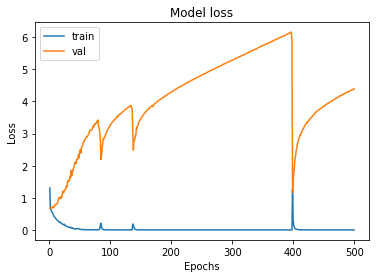

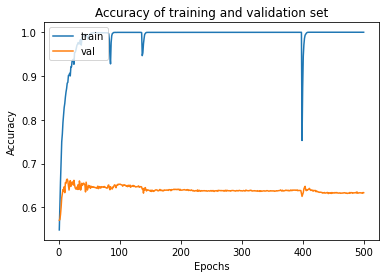

In [39]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Tuning model

##1. Optimizer and learning rates
- Adam
- SGD
- RMSprop

In [62]:
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()
    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [63]:
#results in the previous section: overfit
# model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001))
# history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

#did not get as good results 
# model=make_model_1D(X_train.shape[1:],64,64,100,3,2,SGD(lr=0.001))
# history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


33/33 [==============================] - 4s 85ms/step - loss: 2.0111 - accuracy: 0.5475 - val_loss: 0.7486 - val_accuracy: 0.5328
Epoch 2/100
33/33 [==============================] - 3s 97ms/step - loss: 0.6454 - accuracy: 0.6242 - val_loss: 0.7507 - val_accuracy: 0.5752
Epoch 3/100
33/33 [==============================] - 3s 81ms/step - loss: 0.6104 - accuracy: 0.6678 - val_loss: 0.7616 - val_accuracy: 0.5667
Epoch 4/100
33/33 [==============================] - 3s 81ms/step - loss: 0.5699 - accuracy: 0.7103 - val_loss: 0.7557 - val_accuracy: 0.5982
Epoch 5/100
33/33 [==============================] - 3s 81ms/step - loss: 0.5180 - accuracy: 0.7501 - val_loss: 0.7492 - val_accuracy: 0.5985
Epoch 6/100
33/33 [==============================] - 3s 81ms/step - loss: 0.4691 - accuracy: 0.7828 - val_loss: 0.8763 - val_accuracy: 0.5844
Epoch 7/100
33/33 [==============================] - 3s 81ms/step - loss: 0.4252 - accuracy: 0.8045 - val_loss: 0.8129 - val_accuracy: 0.6201
Epoch 8/100
33/33 

In [64]:
max(history_dict['val_accuracy'])

0.6793785095214844

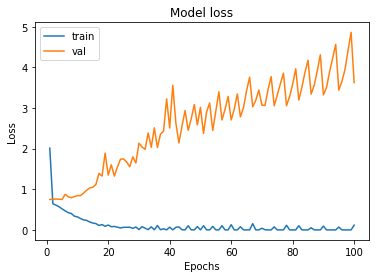

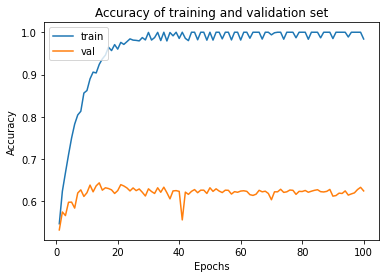

In [65]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##2. Adding dropout
- 0.5
- 0.3

3. Adding Maxpooling
Adding max pool decreased the accuracy from 67 to 65

In [74]:
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    # model.add(layers.MaxPooling1D(pool_size))
    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()

    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [75]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


33/33 [==============================] - 5s 116ms/step - loss: 2.0513 - accuracy: 0.5126 - val_loss: 0.6879 - val_accuracy: 0.5290
Epoch 2/100
33/33 [==============================] - 4s 112ms/step - loss: 0.6853 - accuracy: 0.5606 - val_loss: 0.6825 - val_accuracy: 0.5505
Epoch 3/100
33/33 [==============================] - 4s 111ms/step - loss: 0.6807 - accuracy: 0.5650 - val_loss: 0.6787 - val_accuracy: 0.5696
Epoch 4/100
33/33 [==============================] - 4s 111ms/step - loss: 0.6750 - accuracy: 0.5727 - val_loss: 0.6759 - val_accuracy: 0.5865
Epoch 5/100
33/33 [==============================] - 4s 112ms/step - loss: 0.6695 - accuracy: 0.5895 - val_loss: 0.6722 - val_accuracy: 0.5911
Epoch 6/100
33/33 [==============================] - 4s 111ms/step - loss: 0.6644 - accuracy: 0.5916 - val_loss: 0.6694 - val_accuracy: 0.5830
Epoch 7/100
33/33 [==============================] - 4s 112ms/step - loss: 0.6570 - accuracy: 0.6031 - val_loss: 0.6697 - val_accuracy: 0.5805
Epoch 8/100

In [76]:
max(history_dict['val_accuracy'])

0.6730226278305054

In [86]:

import statistics
for i in range(100):

  mean_loss_diff=statistics.mean(history_dict['val_loss'][i]-history_dict['loss'][i])

mean_loss_diff

TypeError: ignored

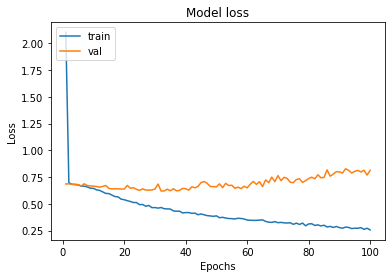

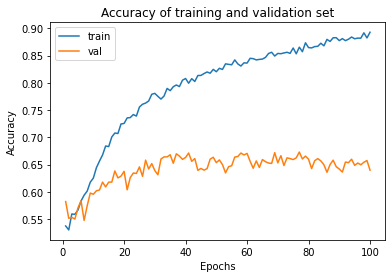

In [73]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##4. Trying different architecture
- Add layers

In [43]:
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size))
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()

    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [44]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 5s 142ms/step - loss: 1.1692 - accuracy: 0.5214 - val_loss: 0.6907 - val_accuracy: 0.5222
Epoch 2/100
33/33 [==============================] - 5s 139ms/step - loss: 0.6943 - accuracy: 0.5403 - val_loss: 0.6907 - val_accuracy: 0.5254
Epoch 3/100
33/33 [==============================] - 5s 137ms/step - loss: 0.6913 - accuracy: 0.5435 - val_loss: 0.6894 - val_accuracy: 0.5374
Epoch 4/100
33/33 [==============================] - 4s 136ms/step - loss: 0.6890 - accuracy: 0.5412 - val_loss: 0.6851 - val_accuracy: 0.5540
Epoch 5/100
33/33 [==============================] - 5s 140ms/step - loss: 0.6855 - accuracy: 0.5524 - val_loss: 0.6847 - val_accuracy: 0.5561
Epoch 6/100
33/33 [==============================] - 7s 209ms/step - loss: 0.6791 - accuracy: 0.5635 - val_loss: 0.6816 - val_accuracy: 0.5671
Epoch 7/100
33/33 [==============================] - 6s 170ms/step - loss: 0.6774 - accuracy: 0.5662 - val_loss: 0.6813 - val_accuracy: 0.5685
Epoch 8/100

In [46]:
max(val_accuracy)

0.6564265489578247

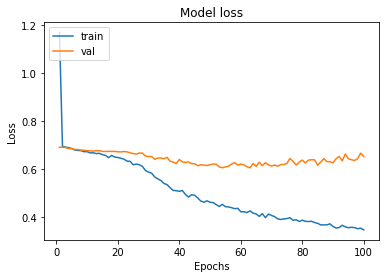

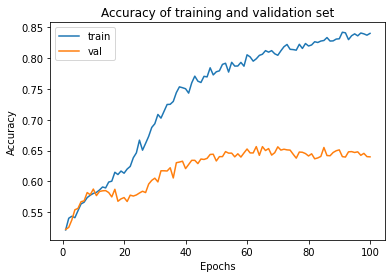

In [45]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##5. Adding regularization
- L2
- L1
- L1_L2
- different weight tested with serch grid later: 0.1, 0.001, and 0.0001

In [57]:
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt,regularizer):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size,kernel_regularizer=regularizer,activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filter_numb2, kernel_size, kernel_regularizer=regularizer,activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size))
    model.add(layers.Conv1D(filter_numb2, kernel_size, kernel_regularizer=regularizer,activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()

    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [58]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001),regularizers.l2(0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 75s 137ms/step - loss: 1.2024 - accuracy: 0.5180 - val_loss: 0.8224 - val_accuracy: 0.5621
Epoch 2/100
33/33 [==============================] - 4s 129ms/step - loss: 0.8207 - accuracy: 0.5366 - val_loss: 0.8171 - val_accuracy: 0.5689
Epoch 3/100
33/33 [==============================] - 4s 130ms/step - loss: 0.8132 - accuracy: 0.5512 - val_loss: 0.8109 - val_accuracy: 0.5819
Epoch 4/100
33/33 [==============================] - 4s 130ms/step - loss: 0.8068 - accuracy: 0.5527 - val_loss: 0.8046 - val_accuracy: 0.5805
Epoch 5/100
33/33 [==============================] - 6s 171ms/step - loss: 0.7965 - accuracy: 0.5765 - val_loss: 0.7985 - val_accuracy: 0.5855
Epoch 6/100
33/33 [==============================] - 6s 186ms/step - loss: 0.7918 - accuracy: 0.5704 - val_loss: 0.7948 - val_accuracy: 0.5830
Epoch 7/100
33/33 [==============================] - 6s 186ms/step - loss: 0.7874 - accuracy: 0.5649 - val_loss: 0.7906 - val_accuracy: 0.5763
Epoch 8/10

In [59]:
max(history_dict['val_accuracy'])

0.6564265489578247

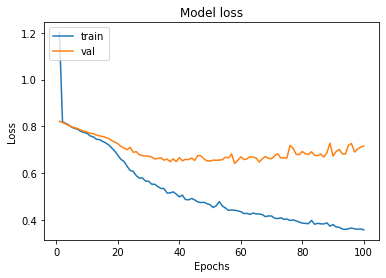

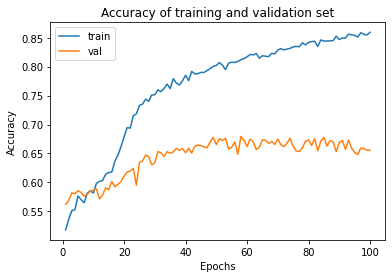

In [60]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#l1 regularization
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001),regularizers.l1(0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

#l1_l2 regularization
# model=make_model_1D(X_train.shape[1:],64,64,100,3,2,Adam(lr=0.001),regularizers.l1_l2(l1=0.001, l2=0.001))
# history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

In [ ]:
max(history_dict['val_accuracy'])

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##6. Tuning hyperparameters with search grid
- number of filter
- kernel size
- batch size
- weight regularization

In [ ]:
def make_model_1D(input_size,filter_numb1,kernel_size,pool_size=2,opt=Adam(lr=0.001),weight_reg):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb, kernel_size,kernel_regularizer=regularizers.l2(weight_reg),activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filter_numb, kernel_size, kernel_regularizer=regularizers.l2(weight_reg),activation='relu',padding='same'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size))

    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb, activation='relu')) 
    model.add(layers.Dense(2, activation='softmax')) 
    # model.summary()

    model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model 

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(make_model_1D,input_size=X_train.shape[1:],filter_numb=64,kernel_size=3,pool_size=2,opt='Adam', weight_reg=0.001)

#call back for epoch and learning rate
# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "model_1", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# call model 

# define the grid search parameters
batch_size = [100, 200] 
filter_numb = [32,64,100] # number filter
kernel_size=[3,5,7] # kernel size
weight_reg=[0.1, 0.001, 0.0001]
param_grid = dict(batch_size=batch_size, filter_numb=filter_numb,kernel_size=kernel_size,weight_reg=weight_reg)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train,validation_data=(X_validation, y_validation)) 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))